In [ ]:
import random
from math import sqrt, factorial, log
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import stats

plt.rc('animation', html='html5')

In [4]:
!jupyter nbconvert --template=nbextensions --to=html MAS_HW_Final.ipynb

[NbConvertApp] Converting notebook MAS_HW_Final.ipynb to html
[NbConvertApp] Writing 2052339 bytes to MAS_HW_Final.html


# Multi-Agent Systems Homework 6

Thomas Maaiveld (t.m.maaiveld@student.vu.nl); 2528586

# 1 $\enspace$ Multi-Armed Bandits

## 1.1 Thompson Sampling for single bandit

Consider a bandit that for each pull of the arm, produces a binary reward: $r = 1$ (with probability $p$)
or $r = 0$ (with probability $1-p$). We model our uncertainty about the actual (but unknown) value
$p$ using a beta-distribution (cf. https://en.wikipedia.org/wiki/Beta_distribution). This
is a probability distribution on the interval $[0, 1]$ which depends on two parameters: $\alpha, \beta \geq 1$.
The explicit distribution is given by (for $\alpha, \beta$ integers!):

\begin{equation}
B(x;\alpha,\beta) = \frac{(\alpha + \beta - 1)!}{(\alpha - 1)!(\beta - 1)!}x^{\alpha - 1}(1-x)^{\beta - 1} \ \ \ \ (\text{for} \ 0 \leq x \leq 1)
\end{equation}

In [5]:
def beta_distribution(a, b, x=np.linspace(0,1,1000)):
    
    result = (factorial(a + b - 1) /                   \
             (factorial(a - 1) * factorial(b - 1))) *  \
             (x**(a - 1) * (1 - x)**(b - 1))          
    
    return result

# this implementation is not used hereafter, as the maximum iteration count is limited by exploding factorials. 
# the scipy.stats package's 'beta' implementation is used instead. 

The parameters $\alpha$ and $\beta$ determine the shape of the distribution:
- If $\alpha = \beta = 1$ then we have the uniform distribution;
- If $\alpha = \beta$ the distribution is symmetric about $x = \frac{1}{2}$.
- If $\alpha > \beta$ the density is right-leaning (i.e. concentrated in the neighbourhood of 1). In fact, one can compute the mean explicitly:

\begin{equation} 
X \sim B(x;\alpha,\beta) \enspace \implies \enspace \mathbb{E}[X] = \frac{\alpha}{\alpha + \beta}
\end{equation}

In [6]:
def beta_EV(a,b):
    return a /(a+b)

Larger values of $\alpha$ and $\beta$ produce a more peaked distribution. This follows from the formula
for the variance:

\begin{equation}
X \sim B(x;\alpha,\beta) \enspace \implies \enspace Var(X) = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha + \beta + 1)}
\end{equation}

In [7]:
def beta_var(a,b):
    return a*b / ((a+b)**2 * (a+b+1))

$\textbf{Thompson update rule}$ Assume that we don't know the success probability $p$ for the bandit.
The Thompson update rule for a single bandit proceeds as follows:
- Initialise $\alpha = \beta = 1$ (resulting in a uniform distribution, indicating that all values for $p$ are equally likely). Now repeat the following loop:
    1. Sample from the bandit and get reward $r$ (either 1 or 0);
    2. Update the values for $\alpha$ and $\beta$ as follows:

\begin{equation}
\alpha \leftarrow \alpha + r \qquad \beta \leftarrow \beta + (1 - r)
\end{equation}

In [8]:
def sample_bandit(p):
    if random.random() < p:
        return 1
    return 0

def update_params(a, b, reward):
    a += reward
    b += 1 - reward
    return float(a), float(b)

$\textbf{Questions}$
- Make  several  plots  of  the  Beta-density  to  illustrate  the  properties  (dependence  on  the  parameters) outlined above.

<font color='blue'>
The following plots show the probability density of $B(x;\alpha,\beta)$ for the different combinations of $\alpha$ and $\beta$ shown in the legend. Noticeable patterns are that higher values for $\alpha$ result in a right-leaning distributions, while higher values for $\beta$ produce a left-leaning distribution. Combinations can be mixed to produce different distributions, while setting either parameter to 1 while the other is greater than 1 leads to a sloped probability distribution function in either direction.
</font>

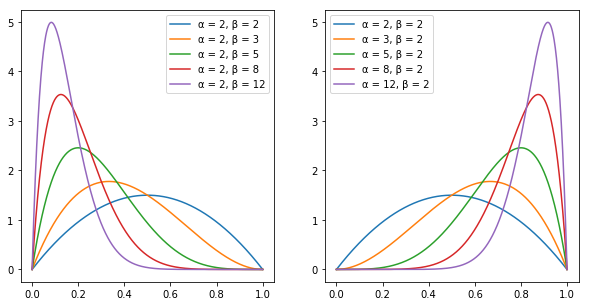

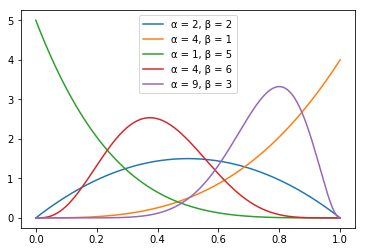

In [9]:
def param_label(a,b):
    return "\u03B1 = " + str(a) + ", \u03B2 = " + str(b)

x = np.linspace(0,1,1000)
example_params = [[(2,2),(2,3),(2,5),(2,8),(2,12)],
                  [(2,2),(3,2),(5,2),(8,2),(12,2)],
                  [(2,2),(4,1),(1,5),(4,6),(9,3)]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(axs)):
    for param in example_params[i]:
        axs[i].plot(x, beta_distribution(*param), label=param_label(*param))
    axs[i].legend()
    
plt.show()

for param in example_params[2]:
    plt.plot(x, beta_distribution(*param), label=param_label(*param))

plt.legend()

plt.show()

- Implement the Thompson update rule and show experimentally that the Beta-density increasingly peaks at the correct value for $p$. Plot both the evolution and the mean and variance over (iteration) time.

<font color='blue'>
The Thompson update rule was implemented and tested with a bandit with a true probability $p=0.3$ of sampling reward $1$. The following two plots show the evolution of the mean over generations, both for the expected value and theoretical variance derived from the beta distribution for updated parameters $\alpha$ and $\beta$, as well as for the values sampled from the bandit in the code above. The expected value for the mean derived for parameters $\alpha$ and $\beta$ closely follows the calculated sample mean for generations of the algorithm (each generation being a sampled reward from the bandit) and approaches it in the limit. The same holds for the variance.
</font>

In [10]:
def thompson_sampling(p, max_iterations, init_params):
    """expand this for k bandits?"""
    
    params, rewards = [init_params], []
    
    for i in range(MAX_IT):        
        reward = sample_bandit(p)
        rewards.append(reward)
        
        a, b = update_params(*params[i], reward)
        params.append([a,b])

    return pd.Series(rewards), np.array(params)

MAX_IT = 1000; INIT_PARAMS = (1,1); p = 0.3 

rewards, params = thompson_sampling(p, MAX_IT, INIT_PARAMS)

expected_means = beta_EV( params[1:,0],params[1:,1])
expected_vrncs = beta_var(params[1:,0],params[1:,1])   
sampled_means = rewards.expanding().mean()
sampled_vrncs = rewards.expanding().var() / (rewards.index + 1)

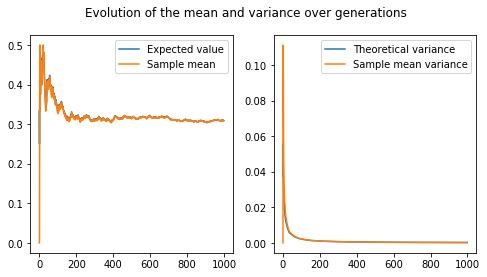

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(range(MAX_IT), expected_means, label="Expected value")
axs[0].plot(range(MAX_IT), sampled_means, label="Sample mean")
axs[0].legend()

axs[1].plot(range(0,MAX_IT), expected_vrncs[0:], label="Theoretical variance")
axs[1].plot(range(0,MAX_IT), sampled_vrncs[0:], label="Sample mean variance")
axs[1].legend()
fig.suptitle('Evolution of the mean and variance over generations')

plt.show()

<font color='blue'>
    The plot and animation below show the evolution of the modeled probability density function of $p$ over generations, distributed according to the beta distribution for computed $\alpha$ and $\beta$ and its convergence towards $p = 0.3$ as samples are drawn from the bandit. The peak approaches  
</font>

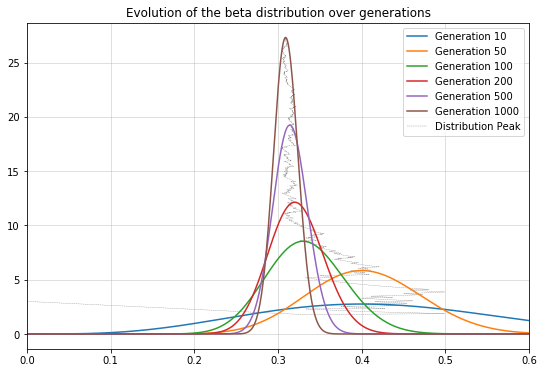

In [12]:
plt.figure(figsize=(9, 6))

peaks = []
draw_cycles = np.array([10,50,100,200,500,1000])

for i, param in enumerate(params):
    
    peaks.append([np.argmax(beta_distribution(*param))/1000,
                  max(beta_distribution(*param))])
    
    if i in draw_cycles:
        plt.plot(x, beta_distribution(*params[i],x),
                 label="Generation " + str(i))

peaks = np.array(peaks)

plt.plot(peaks[:,0],peaks[:,1], linewidth=0.35,
         linestyle='--', color='gray',zorder=-10,
         label='Distribution Peak')

plt.title("Evolution of the beta distribution over generations")
plt.xlim(0.0,0.6)
plt.grid(True, alpha=0.5)
plt.legend()

plt.show()

In [13]:
def init():
    curve.set_data(np.linspace(0,1,1001), beta_distribution(1,1))
    
    plt.axvline(0.3, color='red', linestyle=':',
                linewidth=2, alpha=0.4)
    plt.grid(True, alpha=0.5)
    
    return curve,

def animate(param):

    curve.set_data(x, beta_distribution(*param[1]))
    
    x_max = np.append(line.get_data()[0],
                      np.argmax(beta_distribution(*param[1], x))/1000)
    y_max = np.append(line.get_data()[1],
                      np.max(beta_distribution(*param[1])))                                            
    line.set_data(x_max, y_max)
    
    time_text.set_text("Generation: " + str(param[0]))
        
    return curve, line, time_text

fig = plt.figure(figsize=(9,6))
ax = plt.axes(xlim=(0, 0.6), ylim=(0, max(peaks[:,1])+0.5))

curve, = ax.plot([], [], label="Distribution of p")
line, = ax.plot([],[], linewidth=0.35,
         linestyle='--', color='gray',zorder=-10,
         label='Distribution Peak')


time_text = plt.text(0.025, 25, "", fontsize=12)

anim = FuncAnimation(fig, animate, interval=30, init_func=init,
                     frames=list(enumerate(params))[1:], blit=True)

# plt.legend()
HTML(anim.to_html5_video())
plt.close()

In [14]:
anim

$\textbf{Thompson Sampling}$ Suppose we have a 2-bandit problem. The first one delivers a reward $r = 1$ with (unknown!) probability $p_1$, while the second one does so with (unknown!) probability $p_2$. For each bandit ($k = 1,2$), the uncertainty about the corresponding $p_k$ is modelled using a Beta-distribution with coefficients $\alpha_k, \beta_k$. Thompson sampling now tries to identify the bandit that delivers the maximal output and proceeds as follows:

- Initialise all parameters to 1: $\alpha_k = 1 = \beta_k$; 
Now repeat the following loop:
1. Sample the value $u_k$ for each of the two Beta-distributions: 

\begin{equation}
u_k \sim B(x;\alpha_k,\beta_k)
\end{equation}

2. Determine the max: $k_m = \text{argmax}\{u_1,u_2\}$
3. Sample the corresponding bandit and get reward $r$ (either 1 or 0);
4. Update the corresponding parameters: $\alpha_{k_m}$ and $\beta_{k_m}$ as follows:

\begin{equation}
\alpha_{k_m} \rightarrow \alpha_{k_m} + r \quad
\enspace \text{and} \enspace 
\quad \beta_{k_m} \rightarrow \beta_{k_m} + (1 - r)
\end{equation}

$\textbf{Questions}$
- Write code to implement Thompson sampling for the above scenario;

<font color='blue'>
The setup was implemented using two bandits with true probabilities $p=0.45$ and $p=0.55$. 1000 iterations of the algorithm were used to find the modeled probability distributions of the bandits.
    
The distribution of the inferior bandit ($p = 0.45$) is updated less frequently and takes longer to approach the proper distribution. This is presumably because the $\text{argmax}(u_k)$ will rarely choose $u_k$ for an inferior bandit $k$ if a better sampled $u_k$ is available, meaning its parameters $\alpha_k$ and $\beta_k$ are updated less often.The animation below shows the development of the distribution of $p$ for both bandits. The vertical lines show the  actual values for $p_k$ for each of the $k$ bandits.
</font>

In [15]:
def sample_from(bandit_pdf, x):
    """select from samples x, distributed according to pdf of bandit u."""
    
    x_p = np.cumsum(bandit_pdf) / sum(bandit_pdf)
    sample = x[np.argmax(x_p > random.random())]
    
    return sample


def thompson_sampling(p, MAX_IT):
    
    params = [[(1,1),(1,1)]] 
    x = np.linspace(0,1,1000)
    u = [0]*len(p)
    choices = []
    rewards = []

    for i in range(MAX_IT):

        for k in range(len(u)):
            u[k] = sample_from(stats.beta.pdf(x,*params[-1][k]),x)

        k_m = np.argmax(u)
        choices.append(k_m)

        reward = sample_bandit(p[k_m])
        rewards.append(reward)

        alpha, beta = update_params(*params[-1][k_m], reward)
        
        params.append([params[-1][1-k_m]])
        params[-1].insert(k_m, (alpha, beta))
    
    return params, choices, rewards

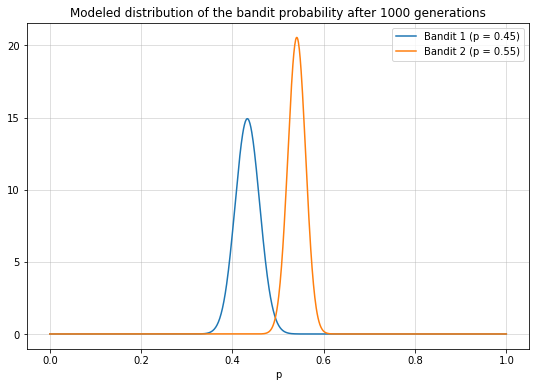

In [16]:
p = [0.45,0.55]; MAX_IT = 1000

params, choices, rewards = thompson_sampling(p, MAX_IT)

plt.figure(figsize=(9,6))

for k in range(len(p)):
    plt.plot(x,stats.beta.pdf(x,*params[-1][k]),
             label= "Bandit {} (p = {})".format(k+1, p[k]))
    
plt.grid(True,alpha=0.5)
plt.title("Modeled distribution of the bandit probability after {} generations".format(MAX_IT))
plt.xlabel("p")
plt.legend()
plt.show()

In [17]:
%%capture

### ANIMATIONS ###

def init():
    curve1.set_data(np.linspace(0,1,1001), beta_distribution(1,1))
    curve2.set_data(np.linspace(0,1,1001), beta_distribution(1,1))
    
    plt.axvline(p[0], linestyle=':', color=curve1.get_color(),
                linewidth=1)
    
    plt.axvline(p[1], linestyle=':', color=curve2.get_color(),
                linewidth=1) 
        
    plt.grid(True, alpha=0.5)
    
    return curve1, curve2


def animate(param_pair):

    curve1.set_data(x, stats.beta.pdf(x, *param_pair[1][0]))
    curve2.set_data(x, stats.beta.pdf(x, *param_pair[1][1]))
    
    x_max1 = np.append(line1.get_data()[0],
                      np.argmax(stats.beta.pdf(x, *param_pair[1][0]))/1000)
    y_max1 = np.append(line1.get_data()[1],
                      np.max(stats.beta.pdf(x, *param_pair[1][0])))                                            
    line1.set_data(x_max1, y_max1)
    
    x_max2 = np.append(line2.get_data()[0],
                      np.argmax(stats.beta.pdf(x, *param_pair[1][1]))/1000)
    y_max2 = np.append(line2.get_data()[1],
                      np.max(stats.beta.pdf(x, *param_pair[1][1])))                                            
    line2.set_data(x_max2, y_max2)
    
    time_text.set_text("Generation: " + str(param_pair[0]))
    line='null'
        
    return curve1, curve2


fig = plt.figure(figsize=(9,6))
ax = plt.axes(xlim=(0, 1), ylim=(0, 25))

curve1, = ax.plot([], [], label="Bandit 1 (p = {})".format(p[0]))
curve2, = ax.plot([], [], label="Bandit 2 (p = {})".format(p[1]))

line1, = ax.plot([],[], linewidth=0.35,
         linestyle='--', color='gray',zorder=-10)
line2, = ax.plot([],[], linewidth=0.35,
         linestyle='--', color='gray',zorder=-10)

time_text = plt.text(0.025, 15, "", fontsize=12)

anim2 = FuncAnimation(fig, animate, interval=30, init_func=init,
                     frames=list(enumerate(params))[1:], blit=True)

HTML(anim2.to_html5_video())

plt.legend()
plt.close()

In [18]:
anim2

- Perform numerical experiments in which you compare Thompson sampling with the UCB and $\epsilon$-greedy approach. Define some performance measures and discuss the performance of each algorithm with respect to these measures.

<font color='blue'>
A setup with two bandits with true probabilities $p=0.3$ and $p=0.7$ was used to show the difference between the three approaches. 20 runs of 2000 episodes were conducted to generate the results. The plots for the average cumulative reward and regret over time for the Thompson sampling, $\epsilon$-greedy and UCB agents are given below, for parameter settings $\epsilon = 0.1$ and $c = 2$. In terms of reward, Thompson performs best, followed by $\epsilon$-greedy and UCB. 

In terms of regret, $\epsilon$-greedy accumulates linear regret over time, as its exploration is fixed. It quickly finds the better bandit of the two, but is forced to choose the other bandit because of the exploration mechanism, meaning it will linearly accumulate regret over time. Thompson and UCB instead follow a logarithmic regret curve, with Thompson acquiring the least regret in the limit.

In the short term, $\epsilon$-greedy exploration performs better than the two other approaches.

Some small performance increase can be achieved by tweaking parameter $c$, but Thompson performs best in terms of regret on the long term. 
</font>

In [19]:
### INITIALIZATION ###

def e_greedy(Q, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0,len(Q)-1)
    return np.random.choice(np.where(Q == Q.max())[0])


def UCB1(Q, choices):
    upper_bounds = [Q_a + conf_bound(len(choices), choices.count(j)) for j, Q_a in enumerate(Q)]
    upper_bounds = np.array(upper_bounds)
    
    return e_greedy(upper_bounds, epsilon=0)
    
    
def conf_bound(t, times_chosen, c=2):
    return sqrt(c * log(t) / times_chosen)


def e_greedy_bandit(p, MAX_IT, epsilon=0.1):
    
    choices = []
    rewards = []
    Q = np.array([0.5,0.5])
    
    for i in range(MAX_IT):
        
        k = e_greedy(Q)
        reward = sample_bandit(p[k])
        
        choices.append(k)
        rewards.append(reward)
        
        Q[k] += (1 / (choices.count(k) + 1)) * (reward - Q[k])
        
    return choices, rewards


def UCB_bandit(p, MAX_IT, c):
    
    choices = [0,1]
    rewards = [0,0]
    Q = [0,0]
        
    for i in range(MAX_IT-2):
        
        k = UCB1(Q, choices)
        reward = sample_bandit(p[k])
        
        choices.append(k)
        rewards.append(reward)
        
        Q[k] += 1 / (choices.count(k) + 1) * (reward - Q[k])
            
    return choices, rewards


### EXPERIMENT DESIGN ###

def bandit_experiment(p, c, max_it, runs):
    
    thompson_rewards_df = pd.DataFrame(0, index=np.arange(max_it), columns=np.arange(runs))
    e_greedy_rewards_df = thompson_rewards_df.copy()
    UCB_rewards_df      = thompson_rewards_df.copy()

    thompson_choices_df = thompson_rewards_df.copy()
    e_greedy_choices_df = thompson_rewards_df.copy()
    UCB_choices_df      = thompson_rewards_df.copy()

    thompson_regret_df  = thompson_rewards_df.copy()
    e_greedy_regret_df  = thompson_rewards_df.copy()
    UCB_regret_df       = thompson_rewards_df.copy()

    for run in range(runs):

        params, choices, rewards = thompson_sampling(p, max_it)
        thompson_choices_df.iloc[:,run] = choices
        thompson_rewards_df.iloc[:,run] = rewards

        choices, rewards = e_greedy_bandit(p, max_it)
        e_greedy_choices_df.iloc[:,run] = choices
        e_greedy_rewards_df.iloc[:,run] = rewards

        choices, rewards = UCB_bandit(p, max_it, c)
        UCB_choices_df.iloc[:,run] = choices
        UCB_rewards_df.iloc[:,run] = rewards
    
    opportunity_gap = max(p) - min(p)
    
    thompson_regret_df  = (1-thompson_choices_df) * opportunity_gap
    e_greedy_regret_df  = (1-e_greedy_choices_df) * opportunity_gap
    UCB_regret_df       = (1-UCB_choices_df) * opportunity_gap
    
    return [thompson_rewards_df, e_greedy_rewards_df, UCB_rewards_df, 
            thompson_regret_df, e_greedy_regret_df, UCB_regret_df]


### VISUALIZATION ###

def plot_results(data, labels, title, iterations=200, method='cumulative', add=False, add_label=" "):
    """Plots experiment results, averaged over runs."""

    data = [stat[:iterations] for stat in data]
    
    for i, entry in enumerate(data):
        if method == 'mean':
            plt.plot(entry.mean(axis=1), label=labels[i])
        elif method == 'cumulative':
            plt.plot(entry.mean(axis=1).expanding().sum(), label=labels[i])
        else:
            plt.plot(entry, label=labels[i])
               
    if not add_label == " ":
        plt.plot(add.expanding().sum(), add_label)
        
    plt.legend()
    plt.title(title)
    plt.show()

In [27]:
c = 2
p = [0.3, 0.7]
MAX_IT = 2000
runs = 20

# small_data = bandit_experiment(p, c, 200, runs)
data = bandit_experiment(p, c, MAX_IT, runs)
labels = ["Thompson", "$\epsilon$-greedy", "UCB"]

# print(small_data)

# processing the results
plot_results(data[0:3], labels[0:3], "Average cumulative reward per step") 
plot_results(data[3:], labels[0:3], "Average cumulative regret per step", iterations=2000)  

TypeError: list indices must be integers or slices, not tuple

# 2 $\enspace$ Reinforcement Learning: Cliff Walking

Consider the cliff-walking example (Sutton & Barto, ex. 6.6 p.108). Assume that the grid has 10 columns and 5 rows (above or in addition to the cliff). This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right and left. Reward is $-1$ on all transitions except:
- the transition to the terminal goal state (G) which has an associated reward of $+20$;
- transitions into the region marked $\textit{The Cliff}$. Stepping into this region incurs a "reward" of $-100$ and also terminates the episode.

<img src="files/cliff_example.png">

$\textbf{Questions}$
1. Use both SARSA and Q-Learning to construct an appropriate policy. Do you observe the difference between the SARSA and Q-learning policies mentioned in the text (safe versus optimal path)? Discuss.

<font color='blue'>
$\epsilon$ was set to $0.1$ for both approaches, and gridworld experiments were conducted. The optimal policies, accumulated average reward per time step and episode time per time step shown below were obtained by using the mode over all policies (a 'majority vote') and averaging over twenty episodes respectively. Each run consisted of 10000 iterations of the game, of which the first 200 are shown in the plot and the rest are used to find the optimal policy. Some areas remain unexplored even after 10000 iterations, since the probability of visiting these is so low.
    
The optimal policies show the expected difference between Q-learning and SARSA. While Q-learning quickly converges to the optimal policy along the cliff, SARSA learns the safer path one step away from the edge. While Q-learning uses $\epsilon$-greedy action selection to determine which states will be visited in order to be updated, it only maximizes the action value over the actions from that next state to estimate its action value. SARSA, on the other hand, takes this exploration into account. Thus, state action pairs that lead to a cliff state show a high reward by maximizing the subsequent action for Q-learning. If it falls off, the negative reward only directly affects the state action pair for the current state, not for the preceding state action pair that led it to the square next to the cliff. If SARSA ends up falling off, the value of the state action pair leading to the cliffside will also receive a penalty, meaning these will rarely be selected. This minimizes the chance of falling off the edge by staying at least two squares away from it, meaning two subsequent exploration rolls would be necessary in order for it to fall. On the other hand, this results in a slower performance, but since the penalty for falling is steep ($+100$), this strategy results in higher average reward.

The plots below show that SARSA (almost) strictly outperforms Q-learning in terms of average reward per episode. Q-learning achieves a lower step count once it finds the optimal policy around $t=100$, as its optimal path is safer. The probability of falling off the cliff is much lower if two exploratory steps are necessary to fail instead of one, which is the policy that SARSA learns.
</font>

In [25]:
### INITIALIZATION ###

def Q_update(Q, s, a, s_prime, R, alpha=0.1, gamma=1):
    
    Q[s+a] += alpha * (R[s_prime] + gamma * max(Q[s_prime]) - Q[s+a])
    return Q

def SARSA_update(Q, s, a, s_prime, a_prime, R, alpha=0.1, gamma=1):
    
    Q[s+a] += alpha * (R[s_prime] + gamma * Q[s_prime+a_prime] - Q[s+a])
    return Q
    
def e_greedy(Q, epsilon=0.1):
    
    if random.random() < epsilon:
        return (random.randint(0,len(Q)-1),)
    
    return (np.random.choice(np.where(Q == Q.max())[0]),)
        
def transition(s, a):
    
    if a == 0:
        if not s[1]+1 > dims[1]-1:
            s = (s[0],s[1]+1)
        
    if a == 1:
        if not s[1]-1 < 0:
            s = (s[0],s[1]-1)
            
    if a == 2:
        if not s[0]-1 < 0:
            s = (s[0]-1,s[1])
        
    if a == 3:
        if not s[0]+1 > dims[0]-1:
            s = (s[0]+1,s[1])
    
    return s

def init_gridworld(dims):
    """Gridworld setup for coordinate tuple (x,y,action)."""
    
    starting_state = (0, 0) 
    terminal_states = [(x,0) for x in range(1,dims[0])]
        
    return starting_state, terminal_states

def init_Q(dims, A):
    
    Q = np.random.rand(*dims, len(A))
    Q[range(1,dims[0]),0] = [0] * len(A)
    
    return Q
    
def init_R(dims):
    
    R = np.array([[-1] * dims[0]] * dims[1])
    R[len(R)-1] = np.array([-1] + [-100] * (dims[0]-2) + [20])
    R = np.flip(R.T,axis=1)
    
    return R


### RL ALGORITHMS ###

def Q_learning(gridworld, Q, R, max_it, epsilon=0.1, verbose=False):
    
    episodes = []
    
    for i in range(max_it):
        
        if verbose == True:
            print('---  Generation {} ---'.format(i))
            
        s, terminal = gridworld

        states = []
        rewards = []
        length = 0

        while not s in terminal: 
            
            a = e_greedy(Q[s], epsilon)

            s_prime = transition(s,*a)
            reward = R[s_prime]

            Q = Q_update(Q, s, a, s_prime, R)
            s = s_prime

            states.append(s)
            rewards.append(reward)
            length += 1
            
        if verbose == True:
            print('episode reward: ', sum(rewards))

        episodes.append((states, rewards, length))
    
    policy = np.argmax(Q, axis=2)
    
    return episodes, policy


def SARSA(gridworld, Q, R, max_it, epsilon=0.1, verbose=False):
    
    episodes = []
    
    for i in range(max_it):
        
        if verbose == True:
            print('---  Generation {} ---'.format(i))
            
        s, terminal = gridworld

        states = []
        rewards = []
        length = 0
        
        a = e_greedy(Q[s], epsilon)
        
        while not s in terminal:  
            
            s_prime = transition(s,*a)
            reward = R[s_prime]
            
            a_prime = e_greedy(Q[s_prime], epsilon)

            Q = SARSA_update(Q, s, a, s_prime, a_prime, R)
            s = s_prime; a = a_prime

            states.append(s)
            rewards.append(reward)
            length += 1
            
        if verbose == True:
            print('episode reward: ', sum(rewards))

        episodes.append((states, rewards, length))
        
    policy = np.argmax(Q, axis=2)
    
    return episodes, policy


### EXPERIMENT DESIGN ###

def cliffworld_experiment(dims, A, epsilon, max_it, runs):
    
    results = []
    
    for i, epsilon_setting in enumerate(epsilon):
        Q_rewards     = pd.DataFrame(index=np.arange(MAX_IT), columns=np.arange(runs))
        SARSA_rewards = Q_rewards.copy()
        Q_lengths     = Q_rewards.copy()
        SARSA_lengths = Q_rewards.copy()
        Q_policy      = [0] * runs
        SARSA_policy  = [0] * runs
        Q_regret      = Q_rewards.copy()
        SARSA_regret  = Q_rewards.copy()

        for run in range(runs):

            Q = init_Q(dims, A)
            gridworld = init_gridworld(dims)
            R = init_R(dims)

            episodes_Q, Q_policy[run]         = Q_learning(gridworld, Q, R, MAX_IT, epsilon_setting)
            episodes_SARSA, SARSA_policy[run] = SARSA(gridworld, Q, R, MAX_IT, epsilon_setting)

            Q_rewards.iloc[:,run]     = pd.Series([sum(ep_data[1]) for ep_data in episodes_Q])
            SARSA_rewards.iloc[:,run] = pd.Series([sum(ep_data[1]) for ep_data in episodes_SARSA])

            Q_lengths.iloc[:,run]     = pd.Series([ep_data[2] for ep_data in episodes_Q])
            SARSA_lengths.iloc[:,run] = pd.Series([ep_data[2] for ep_data in episodes_SARSA])

        results.append((Q_rewards, SARSA_rewards, Q_lengths, SARSA_lengths, Q_policy, SARSA_policy))
    
    return results


### VISUALIZATION ###

def print_moves(ep_policies, title=""):

    print(title)
    
    policy = stats.mode(ep_policies, axis=0)[0][0]
    
    symbols = [u"\u2191", u"\u2193", u"\u2190", u"\u2192", u"\u00D7", u"\u2691"]
    policy_map = []
    
    for row in policy:
        for action in row:
            policy_map.append(symbols[action])
    
    policy_map = np.reshape(policy_map, dims)
        
    policy_map[1:,0] = symbols[4]
    policy_map[-1,0] = symbols[5]
    
    print(np.array(np.rot90(policy_map)), '\n') 

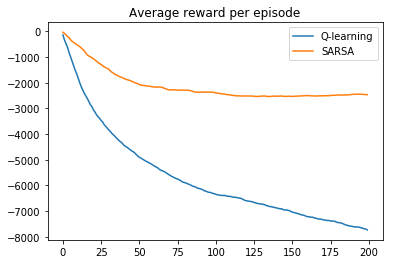

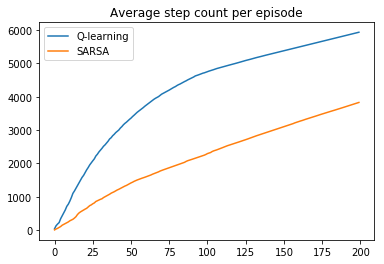

Average optimal policy (Q-learning)
[['↑' '→' '↑' '↓' '→' '↑' '↑' '↑' '→' '↑']
 ['→' '→' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '×' '×' '×' '×' '×' '×' '×' '×' '⚑']] 

Average optimal policy (SARSA)
[['↓' '↑' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '→' '↓']
 ['↑' '×' '×' '×' '×' '×' '×' '×' '×' '⚑']] 



In [26]:
dims = (10,6)
A = [0,1,2,3]
epsilon = [0.1]
runs = 20
MAX_IT = 10000

data = cliffworld_experiment(dims, A, epsilon, MAX_IT, runs)[0]

labels = ["Q-learning", "SARSA"]

plot_results(data[0:2], labels, "Average reward per episode")
plot_results(data[2:4], labels, "Average step count per episode")

print_moves(data[4], "Average optimal policy (Q-learning)")
print_moves(data[5], "Average optimal policy (SARSA)")

2. Try different values for $\epsilon$ (parameter for $\epsilon$-greedy policy). How does the value of $\epsilon$ influence the result? Discuss.

<font color='blue'>
The code below shows a comparison for different parameter settings ($\epsilon=0.1$, $\epsilon=0.3$ and $\epsilon=0.5$). The results are averaged over 30 runs, and optimal policies were chosen by majority vote for each state over runs. Increasing $\epsilon$ has a significant effect on the reward and episode length as generations increase. Both algorithms take more episodes to maximize their score and are also able to achieve significantly less total reward after many episodes as they tumble off the cliff more often when choosing exploring actions. 
    
SARSA's policy becomes more conservative as $\epsilon$ increases. For $\epsilon=0.5$, almost the entire path (found by following the arrows) has moved back two squares from where it was for $\epsilon=0.3$. Since Q-learning does not take exploration into account when assessing the value of a state action pair, its optimal policy doesn't change. As a result, the maximum average reward over episodes achieved gradually decreases for larger $\epsilon$. 

Clearly, introducing increasing amounts of stochasticity to this environment show an advantage SARSA has over Q-learning. Its accumulated reward also decreases as it is forced to take a longer path, but this is notably less than the detriment to Q-learning's performance. 
</font>

In [ ]:
dims = (10,6)
A = [0,1,2,3]
epsilon = [0.1, 0.3, 0.5]
MAX_IT = 1000
runs = 20

results = cliffworld_experiment(dims, A, epsilon, MAX_IT, runs)

for i, result in enumerate(results):
    plot_results(result[0:2], labels, 
                 "Average reward over episodes ($\epsilon = {}$)".format(epsilon[i]), iterations=300)

    plot_results(result[2:4], labels,  
                 "Average step count over episodes ($\epsilon = {}$)".format(epsilon[i]), iterations=300)
    
    print_moves(result[4], "Aggregated optimal policy (Q-learning)")
    print_moves(result[5], "Aggregated optimal policy (SARSA)")